### Insurance Fraud Detection

Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")


import os
import re
import json
from datetime import datetime
from datetime import date

#dataframe manipulation
import numpy as np
import pandas as pd

#visualisations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import seaborn as sns
import matplotlib.dates as mdates
plt.style.use('bmh')
from sklearn.metrics import mean_squared_error

#time series data
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#### Import file

In [14]:
df = pd.read_excel("fraud_data.xlsx", sheet_name = 'Data')
df.head(4)

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  \
0          Jan                   1  Female        Single  ...   
1          Jan                   4    Male        Single  ...   
2          Nov                   2    Male       Married  ...   
3          Jul                   1    Male       Married  ...   

   AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0           26 to 30                No             No  External   
1           31 to 35               Yes             No  External   
2           41 to 50                No             No  External   
3           51 to 65               Yes             No  External   

  NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  BasePolicy  \
0                none               1 year        3 to 4  1994   Liability   
1                none            no change     1 vehicle  1994   Collision   
2                none            no change     1 vehicle  1994   Collision   
3         more than 5            no change     1 vehicle  1994   Liability   

   Month-Year  
0    Dec-1994  
1    Jan-1994  
2    Oct-1994  
3    Jun-1994  

[4 rows x 34 columns]

#### Exploratory Descriptive Analysis

In [4]:
df.shape

(15420, 33)

There are 33 columns in total with 15420 cases in the dataset

#### Descriptive Analysis - Continuous Variables - Univariate

There are 4 continuous variables in the dataset. These are as follows:
* WeekofMonth
* WeekofMonthClaimed
* Age
* Deductible

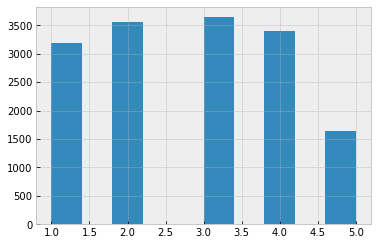

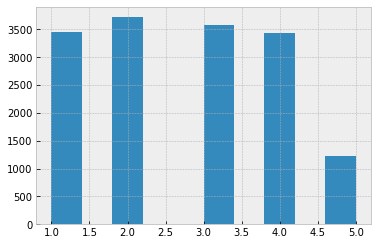

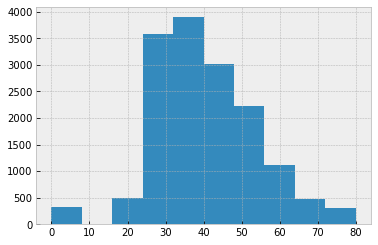

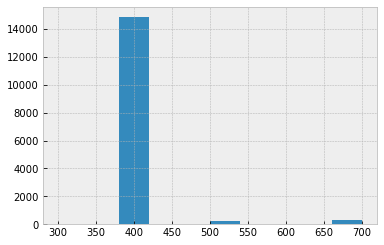

In [5]:
cont_variables = (df['WeekOfMonth'], df['WeekOfMonthClaimed'], df['Age'], df['Deductible'])

for column in cont_variables:
    x = column
    plt.hist(x, bins=10)
    plt.show()


##### Read in GDP data

In [13]:
gdp =  pd.read_excel("fredgraph.xlsx", sheet_name = 'Sheet2')
gdp.head(3)

observation_date       GDP  GDP_PCH  Quarter
0       1994-01-01  7115.652  1.45306  Q1 1994
1       1994-04-01  7246.931  1.84493  Q2 1994
2       1994-07-01  7331.075  1.16110  Q3 1994

In [15]:
df.head(3)

Month  WeekOfMonth  DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday  Honda        Urban          Tuesday   
1   Jan            3  Wednesday  Honda        Urban           Monday   
2   Oct            5     Friday  Honda        Urban         Thursday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  \
0          Jan                   1  Female        Single  ...   
1          Jan                   4    Male        Single  ...   
2          Nov                   2    Male       Married  ...   

   AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0           26 to 30                No             No  External   
1           31 to 35               Yes             No  External   
2           41 to 50                No             No  External   

  NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  BasePolicy  \
0                none               1 year        3 to 4  1994   Liability   
1                none            no change     1 vehicle  1994   Collision   
2                none            no change     1 vehicle  1994   Collision   

   Month-Year  
0    Dec-1994  
1    Jan-1994  
2    Oct-1994  

[3 rows x 34 columns]

In [16]:
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [18]:
df['Month-Year']=pd.to_datetime(df['Month-Year']).dt.normalize()

In [20]:
df['quarter'] = df['Month-Year'].dt.to_period('Q')
df.head(3)

Month  WeekOfMonth  DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday  Honda        Urban          Tuesday   
1   Jan            3  Wednesday  Honda        Urban           Monday   
2   Oct            5     Friday  Honda        Urban         Thursday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  \
0          Jan                   1  Female        Single  ...   
1          Jan                   4    Male        Single  ...   
2          Nov                   2    Male       Married  ...   

   PoliceReportFiled WitnessPresent AgentType NumberOfSuppliments  \
0                 No             No  External                none   
1                Yes             No  External                none   
2                 No             No  External                none   

  AddressChange_Claim  NumberOfCars  Year  BasePolicy  Month-Year  quarter  
0              1 year        3 to 4  1994   Liability  1994-12-01   1994Q4  
1           no change     1 vehicle  1994   Collision  1994-01-01   1994Q1  
2           no change     1 vehicle  1994   Collision  1994-10-01   1994Q4  

[3 rows x 35 columns]

In [32]:
#df['gdp'] = df['quarter'].map(lambda x: '1994Q1' if x == 7115.652 else x)
df['gdp'] = df['gdp'].replace({'1994Q1':7115.652})

In [33]:
df.head(7)

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   
5   Oct            4     Friday   Honda        Urban        Wednesday   
6   Feb            1   Saturday   Honda        Urban           Monday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  WitnessPresent  \
0          Jan                   1  Female        Single  ...              No   
1          Jan                   4    Male        Single  ...              No   
2          Nov                   2    Male       Married  ...              No   
3          Jul                   1    Male       Married  ...              No   
4          Feb                   2  Female        Single  ...              No   
5          Nov                   1    Male        Single  ...              No   
6          Feb                   3    Male       Married  ...              No   

  AgentType NumberOfSuppliments AddressChange_Claim NumberOfCars  Year  \
0  External                none              1 year       3 to 4  1994   
1  External                none           no change    1 vehicle  1994   
2  External                none           no change    1 vehicle  1994   
3  External         more than 5           no change    1 vehicle  1994   
4  External                none           no change    1 vehicle  1994   
5  External              3 to 5           no change    1 vehicle  1994   
6  External              1 to 2           no change    1 vehicle  1994   

   BasePolicy  Month-Year  quarter     gdp  
0   Liability  1994-12-01   1994Q4  1994Q4  
1   Collision  1994-01-01   1994Q1  1994Q1  
2   Collision  1994-10-01   1994Q4  1994Q4  
3   Liability  1994-06-01   1994Q2  1994Q2  
4   Collision  1994-01-01   1994Q1  1994Q1  
5   Collision  1994-10-01   1994Q4  1994Q4  
6   Collision  1994-02-01   1994Q1  1994Q1  

[7 rows x 36 columns]

In [34]:
df.to_excel('New.xlsx')

In [70]:
df1 = pd.read_excel('New.xlsx')
df1

Unnamed: 0 Month  WeekOfMonth  DayOfWeek     Make AccidentArea  \
0               0   Dec            5  Wednesday    Honda        Urban   
1               1   Jan            3  Wednesday    Honda        Urban   
2               2   Oct            5     Friday    Honda        Urban   
3               3   Jun            2   Saturday   Toyota        Rural   
4               4   Jan            5     Monday    Honda        Urban   
...           ...   ...          ...        ...      ...          ...   
15415       15415   Nov            4     Friday   Toyota        Urban   
15416       15416   Nov            5   Thursday  Pontiac        Urban   
15417       15417   Nov            5   Thursday   Toyota        Rural   
15418       15418   Dec            1     Monday   Toyota        Urban   
15419       15419   Dec            2  Wednesday   Toyota        Urban   

      DayOfWeekClaimed MonthClaimed  WeekOfMonthClaimed     Sex  ...  \
0              Tuesday          Jan                   1  Female  ...   
1               Monday          Jan                   4    Male  ...   
2             Thursday          Nov                   2    Male  ...   
3               Friday          Jul                   1    Male  ...   
4              Tuesday          Feb                   2  Female  ...   
...                ...          ...                 ...     ...  ...   
15415          Tuesday          Nov                   5    Male  ...   
15416           Friday          Dec                   1    Male  ...   
15417           Friday          Dec                   1    Male  ...   
15418         Thursday          Dec                   2  Female  ...   
15419         Thursday          Dec                   3    Male  ...   

      WitnessPresent  AgentType NumberOfSuppliments AddressChange_Claim  \
0                 No   External                none              1 year   
1                 No   External                none           no change   
2                 No   External                none           no change   
3                 No   External         more than 5           no change   
4                 No   External                none           no change   
...              ...        ...                 ...                 ...   
15415             No   External                none           no change   
15416             No   External         more than 5           no change   
15417             No   External              1 to 2           no change   
15418             No   External         more than 5           no change   
15419             No   External              1 to 2           no change   

      NumberOfCars  Year  BasePolicy  Month-Year  quarter       gdp  
0           3 to 4  1994   Liability  1994-12-01   1994Q4  7455.288  
1        1 vehicle  1994   Collision  1994-01-01   1994Q1  7115.652  
2        1 vehicle  1994   Collision  1994-10-01   1994Q4  7455.288  
3        1 vehicle  1994   Liability  1994-06-01   1994Q2  7246.931  
4        1 vehicle  1994   Collision  1994-01-01   1994Q1  7115.652  
...            ...   ...         ...         ...      ...       ...  
15415    1 vehicle  1996   Collision  1996-11-01   1996Q4  8259.771  
15416       3 to 4  1996   Liability  1996-11-01   1996Q4  8259.771  
15417    1 vehicle  1996   Collision  1996-11-01   1996Q4  8259.771  
15418    1 vehicle  1996  All Perils  1996-12-01   1996Q4  8259.771  
15419    1 vehicle  1996   Collision  1996-12-01   1996Q4  8259.771  

[15420 rows x 37 columns]

In [71]:
#df1 = df1.drop(columns='Unnamed: 0')
df1['FraudFound_P'] = df1['FraudFound_P'].astype(str)

In [72]:
df1['FraudFound_P'] = df1['FraudFound_P'].str.replace('1', 'Yes')
df1['FraudFound_P'] = df1['FraudFound_P'].str.replace('0', 'No')

In [73]:
df1['FraudFound_P']

0         No
1         No
2         No
3         No
4         No
        ... 
15415    Yes
15416     No
15417    Yes
15418     No
15419    Yes
Name: FraudFound_P, Length: 15420, dtype: object

In [3]:
#Read in updated fraud data
df1 = pd.read_excel('New.xlsx')
df1

Unnamed: 0 Month Month_Calc  WeekOfMonth  DayOfWeek     Make  \
0               0   Dec 1900-01-12            5  Wednesday    Honda   
1               1   Jan 1900-01-01            3  Wednesday    Honda   
2               2   Oct 1900-01-10            5     Friday    Honda   
3               3   Jun 1900-01-06            2   Saturday   Toyota   
4               4   Jan 1900-01-01            5     Monday    Honda   
...           ...   ...        ...          ...        ...      ...   
15415       15415   Nov 1900-01-11            4     Friday   Toyota   
15416       15416   Nov 1900-01-11            5   Thursday  Pontiac   
15417       15417   Nov 1900-01-11            5   Thursday   Toyota   
15418       15418   Dec 1900-01-12            1     Monday   Toyota   
15419       15419   Dec 1900-01-12            2  Wednesday   Toyota   

      AccidentArea DayOfWeekClaimed MonthClaimed MonthClaim_Calc  ...  \
0            Urban          Tuesday          Jan      1900-01-01  ...   
1            Urban           Monday          Jan      1900-01-01  ...   
2            Urban         Thursday          Nov      1900-01-11  ...   
3            Rural           Friday          Jul      1900-01-07  ...   
4            Urban          Tuesday          Feb      1900-01-02  ...   
...            ...              ...          ...             ...  ...   
15415        Urban          Tuesday          Nov      1900-01-11  ...   
15416        Urban           Friday          Dec      1900-01-12  ...   
15417        Rural           Friday          Dec      1900-01-12  ...   
15418        Urban         Thursday          Dec      1900-01-12  ...   
15419        Urban         Thursday          Dec      1900-01-12  ...   

       WitnessPresent AgentType NumberOfSuppliments  AddressChange_Claim  \
0                  No  External                none               1 year   
1                  No  External                none            no change   
2                  No  External                none            no change   
3                  No  External         more than 5            no change   
4                  No  External                none            no change   
...               ...       ...                 ...                  ...   
15415              No  External                none            no change   
15416              No  External         more than 5            no change   
15417              No  External              1 to 2            no change   
15418              No  External         more than 5            no change   
15419              No  External              1 to 2            no change   

      NumberOfCars  Year  BasePolicy Month-Year  quarter       gdp  
0           3 to 4  1994   Liability 1994-12-01   1994Q4  7455.288  
1        1 vehicle  1994   Collision 1994-01-01   1994Q1  7115.652  
2        1 vehicle  1994   Collision 1994-10-01   1994Q4  7455.288  
3        1 vehicle  1994   Liability 1994-06-01   1994Q2  7246.931  
4        1 vehicle  1994   Collision 1994-01-01   1994Q1  7115.652  
...            ...   ...         ...        ...      ...       ...  
15415    1 vehicle  1996   Collision 1996-11-01   1996Q4  8259.771  
15416       3 to 4  1996   Liability 1996-11-01   1996Q4  8259.771  
15417    1 vehicle  1996   Collision 1996-11-01   1996Q4  8259.771  
15418    1 vehicle  1996  All Perils 1996-12-01   1996Q4  8259.771  
15419    1 vehicle  1996   Collision 1996-12-01   1996Q4  8259.771  

[15420 rows x 39 columns]

In [5]:
#Calculate difference in days
#df1['Month_Calc'] = pd.to_datetime(df1['Month_Calc']).dt.strftime('%d-%m-%Y')
#df1['MonthClaim_Calc'] = pd.to_datetime(df1['MonthClaim_Calc']).dt.strftime('%d-%m-%Y')

#df1['Month_Calc'] = pd.to_datetime(df1['Month_Calc'].str.strip(), format = '%m-%d-%Y')
#df1['MonthClaim_Calc'] = pd.to_datetime(df1['MonthClaim_Calc'].str.strip(), format = '%m-%d-%Y')

#df['Time stamp'] = pd.to_datetime(df['Time stamp'].str.strip(), format='%d/%m/%Y')

df1

AttributeError: Can only use .str accessor with string values!

In [103]:
df1['Days_Diff'] = df1['MonthClaim_Calc'] - df1['Month_Calc']

In [104]:
df1.head(3)

Unnamed: 0 Month Month_Calc  WeekOfMonth  DayOfWeek   Make AccidentArea  \
0           0   Dec 1900-01-12            5  Wednesday  Honda        Urban   
1           1   Jan 1900-01-01            3  Wednesday  Honda        Urban   
2           2   Oct 1900-01-10            5     Friday  Honda        Urban   

  DayOfWeekClaimed MonthClaimed MonthClaim_Calc  ...  AgentType  \
0          Tuesday          Jan      1900-01-01  ...   External   
1           Monday          Jan      1900-01-01  ...   External   
2         Thursday          Nov      1900-11-01  ...   External   

  NumberOfSuppliments AddressChange_Claim  NumberOfCars  Year BasePolicy  \
0                none              1 year        3 to 4  1994  Liability   
1                none           no change     1 vehicle  1994  Collision   
2                none           no change     1 vehicle  1994  Collision   

  Month-Year quarter       gdp  Days_Diff  
0 1994-12-01  1994Q4  7455.288   -11 days  
1 1994-01-01  1994Q1  7115.652     0 days  
2 1994-10-01  1994Q4  7455.288   295 days  

[3 rows x 40 columns]

In [78]:
#build logistic regression model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#create dummy variables

#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8